In [4]:
from music21 import converter, note, chord, stream
import matplotlib.pyplot as plt

midi_file_name = 'sample.mid'

def midi_stats(midi_path):
    midi = converter.parse(midi_path)
    notes = []
    durations = []
    polyphony_count = 0

    for el in midi.flat.notes:
        if isinstance(el, note.Note):
            notes.append(el.pitch.midi)
            durations.append(el.duration.quarterLength)
        elif isinstance(el, chord.Chord):
            notes.extend(p.midi for p in el.pitches)
            durations.append(el.duration.quarterLength)
            polyphony_count += 1

    print(f"Total notes: {len(notes)}")
    print(f"Polyphonic events: {polyphony_count}")
    print(f"Average duration: {sum(durations)/len(durations):.2f}")

    plt.hist(notes, bins=range(min(notes), max(notes)+1))
    plt.title("Pitch Distribution")
    plt.xlabel("MIDI Pitch")
    plt.ylabel("Count")
    plt.show()

Total notes: 176
Polyphonic events: 17
Average duration: 0.25


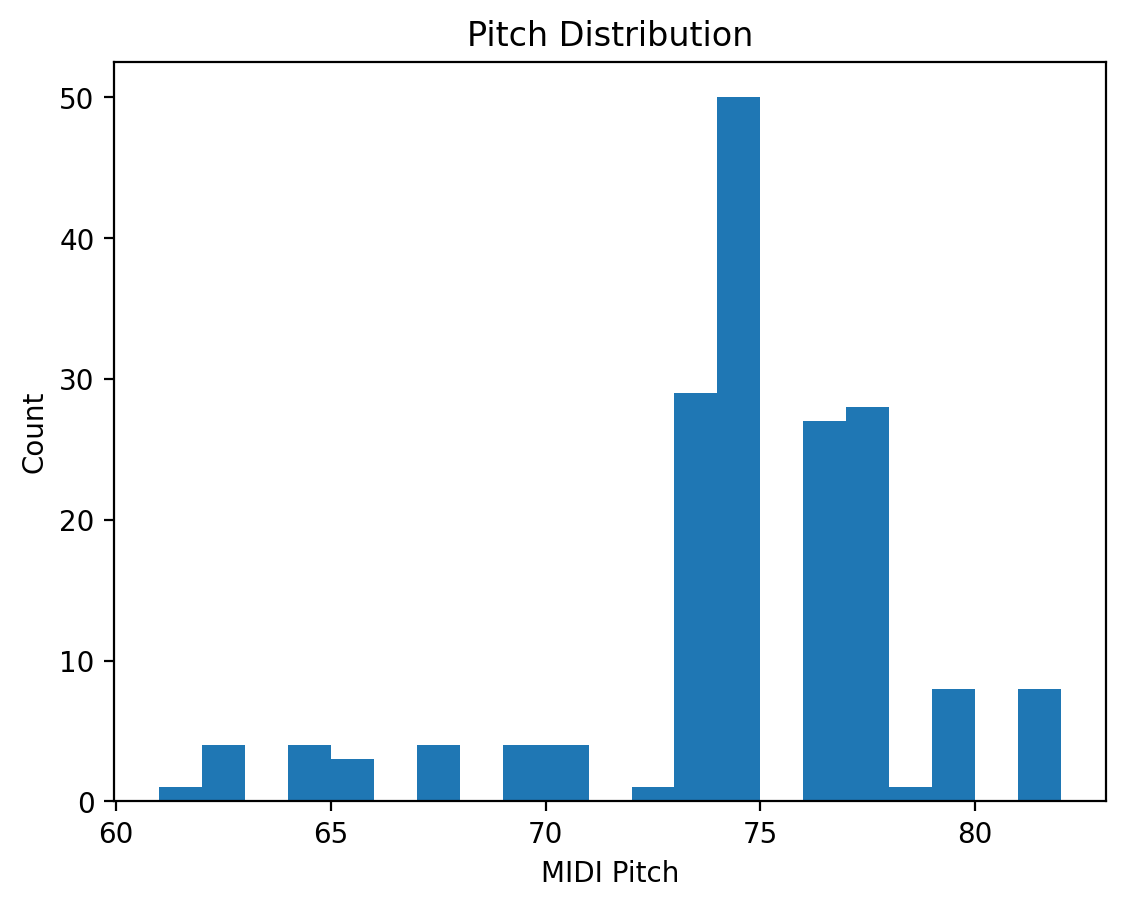

In [5]:
midi_stats(midi_file_name)

In [9]:
import os
import random
from collections import defaultdict
from music21 import converter, note, stream

def extract_notes_from_directory(midi_dir):
    sequences = []
    for file in os.listdir(midi_dir):
        if file.endswith(".midi"):
            midi = converter.parse(os.path.join(midi_dir, file))
            notes = []
            for el in midi.flat.notes:
                if isinstance(el, note.Note):
                    notes.append(el.pitch.midi)
                elif isinstance(el, note.Rest):
                    continue
            if notes:
                sequences.append(notes)
    return sequences

def build_markov_model(sequences):
    model = defaultdict(lambda: defaultdict(int))
    for seq in sequences:
        for i in range(len(seq) - 1):
            curr_note, next_note = seq[i], seq[i + 1]
            model[curr_note][next_note] += 1
    transition_probs = {}
    for curr_note, next_notes in model.items():
        total = sum(next_notes.values())
        transition_probs[curr_note] = {
            n: count / total for n, count in next_notes.items()
        }
    return transition_probs

def generate_notes(transition_probs, start_note=None, length=50):
    if start_note is None:
        start_note = random.choice(list(transition_probs.keys()))
    sequence = [start_note]
    for _ in range(length - 1):
        current = sequence[-1]
        nexts = transition_probs.get(current)
        if not nexts:
            current = random.choice(list(transition_probs.keys()))
        else:
            notes, probs = zip(*nexts.items())
            current = random.choices(notes, probs)[0]
        sequence.append(current)
    return sequence

def notes_to_midi(notes, filename="generated.mid", duration=0.5):
    s = stream.Stream()
    for pitch in notes:
        n = note.Note(pitch)
        n.quarterLength = duration
        s.append(n)
    s.write("midi", fp=filename)

midi_dir = "music_data/maestro-v3.0.0/2018/"  
sequences = extract_notes_from_directory(midi_dir)
transition_probs = build_markov_model(sequences)
generated_notes = generate_notes(transition_probs, length=50)
notes_to_midi(generated_notes, filename="sample_generated.mid")

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from music21 import converter, note, chord

def extract_pitch_classes(midi_file):
    midi = converter.parse(midi_file)
    pitches = []
    for el in midi.flat.notes:
        if isinstance(el, note.Note):
            pitches.append(el.pitch.midi % 12)
        elif isinstance(el, chord.Chord):
            pitches.extend([p.midi % 12 for p in el.pitches])
    return pitches

def compute_pitch_class_histogram(pitch_classes):
    histogram, _ = np.histogram(pitch_classes, bins=12, range=(0, 12), density=True)
    return histogram

def compute_pitch_class_transition_matrix(pitch_classes):
    matrix = np.zeros((12, 12))
    for i in range(len(pitch_classes) - 1):
        current_pc = pitch_classes[i]
        next_pc = pitch_classes[i + 1]
        matrix[current_pc, next_pc] += 1
    row_sums = matrix.sum(axis=1, keepdims=True)
    matrix = matrix / np.maximum(row_sums, 1)  # normalize per row
    return matrix

def plot_histogram(histogram, title, filename=None):
    labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    plt.figure(figsize=(8, 4))
    plt.bar(labels, histogram)
    plt.title(title)
    plt.ylabel("Normalized Frequency")
    if filename:
        plt.savefig(filename)
    plt.show()

def plot_transition_matrix(matrix, title, filename=None):
    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, cmap='viridis')
    plt.colorbar()
    plt.xticks(ticks=range(12), labels=['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'], rotation=45)
    plt.yticks(ticks=range(12), labels=['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
    plt.title(title)
    plt.xlabel("Next Pitch Class")
    plt.ylabel("Current Pitch Class")
    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()

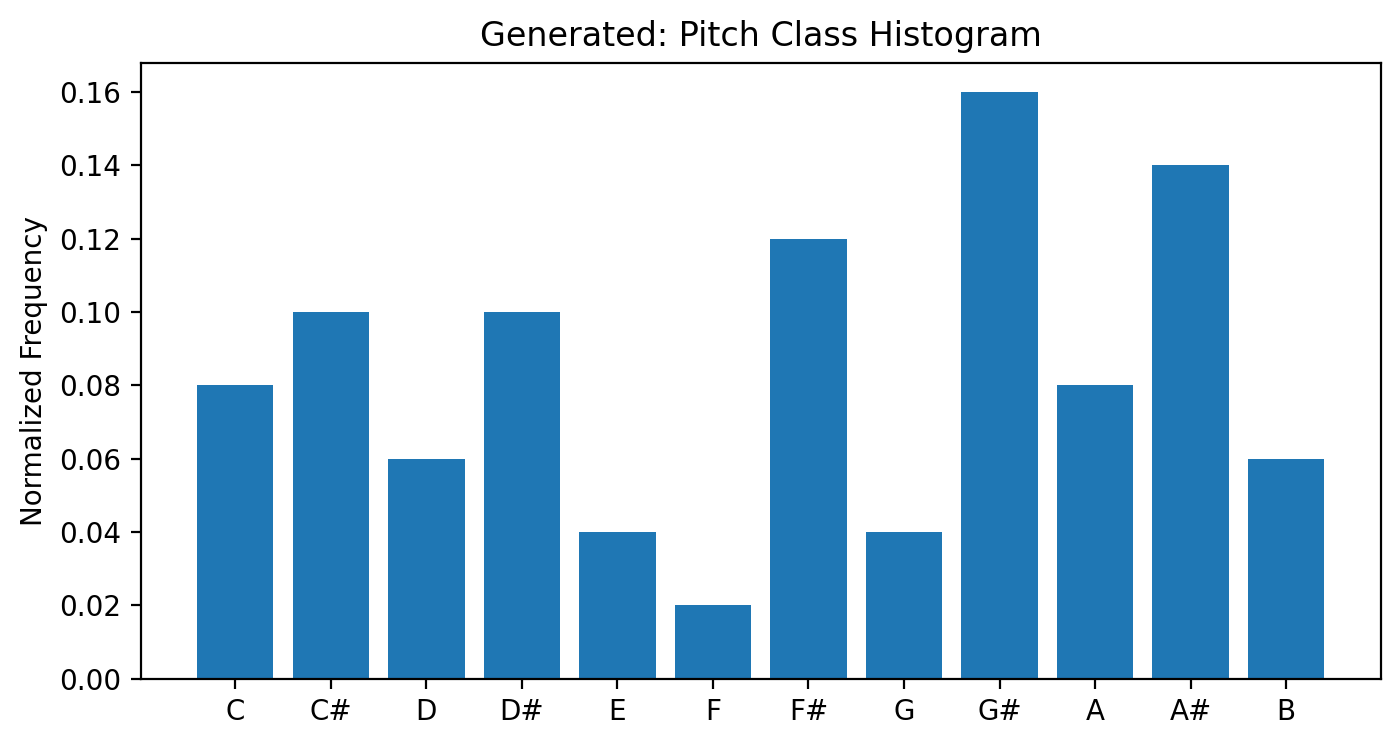

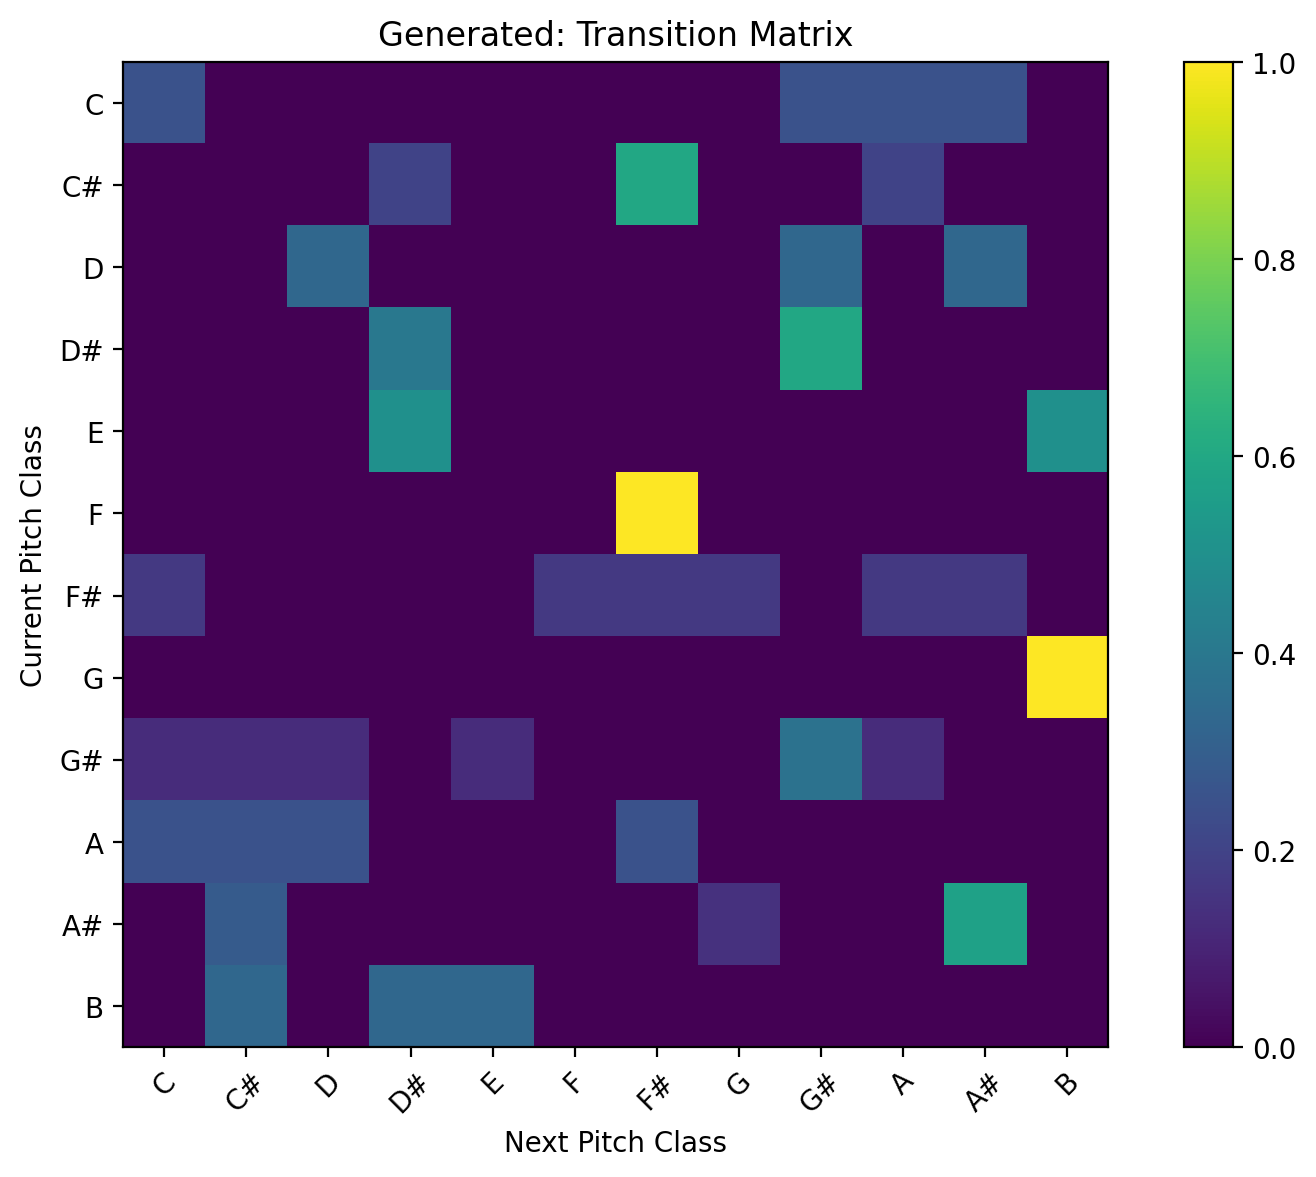

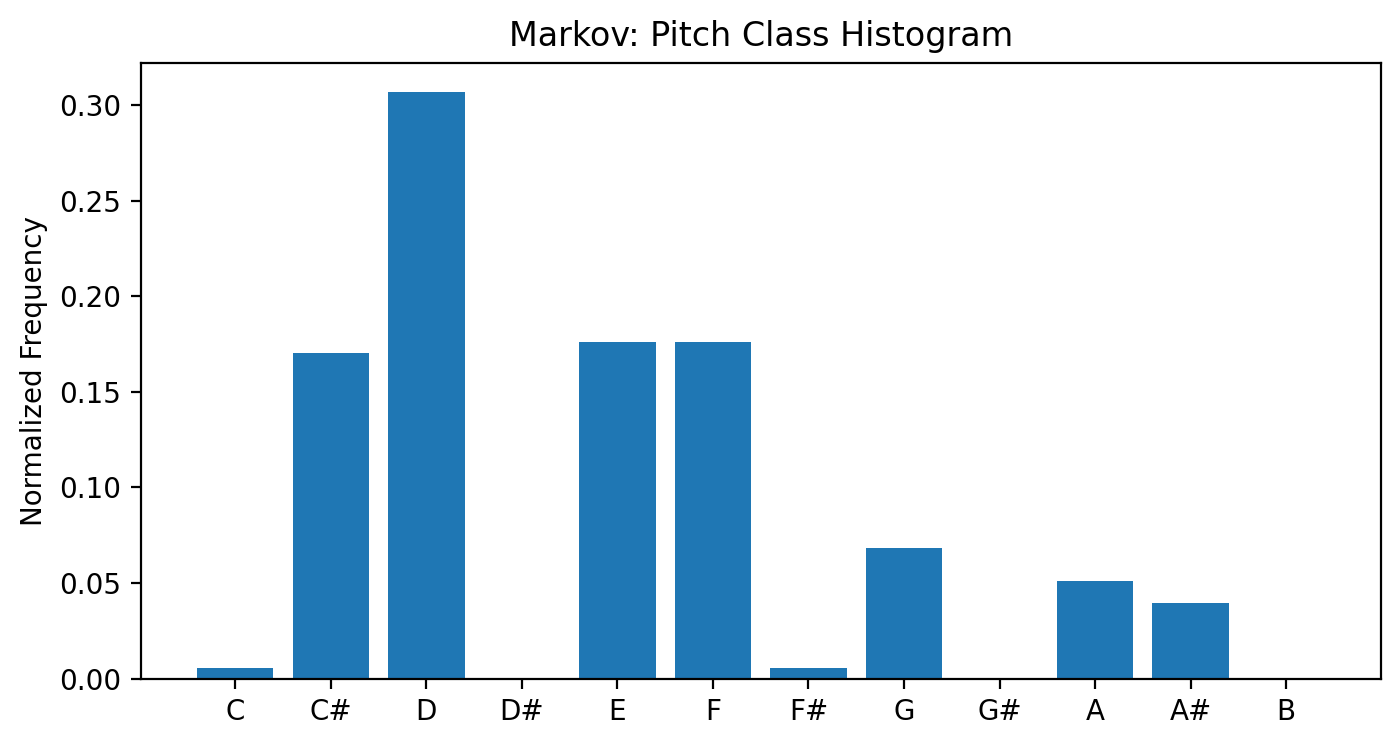

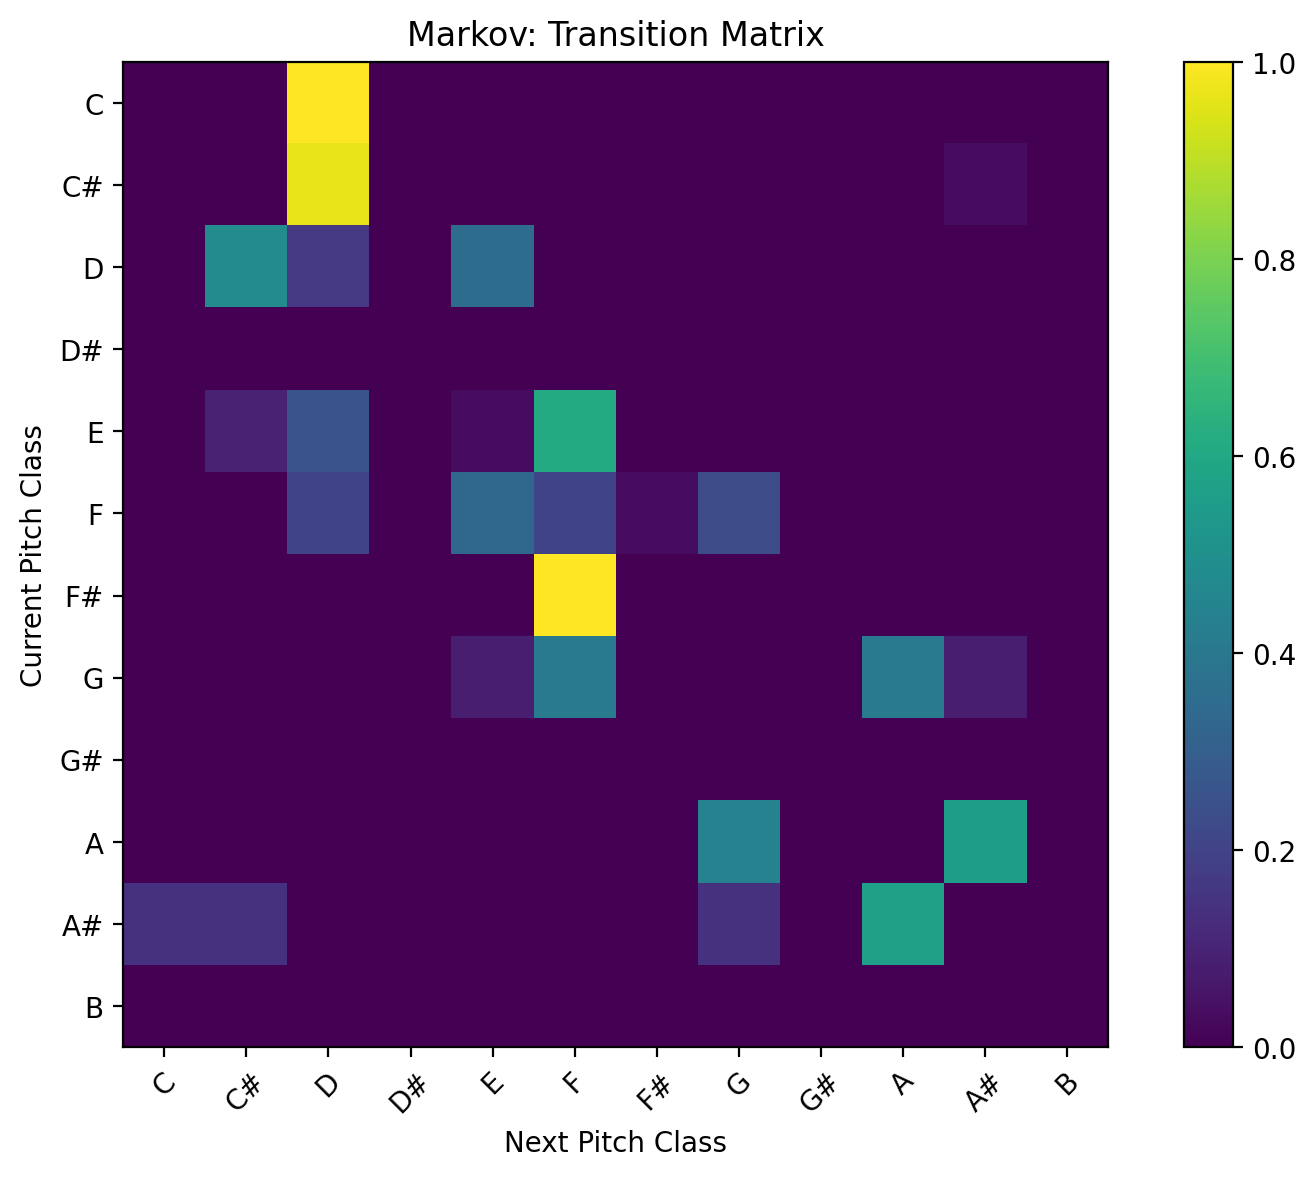

In [22]:
generated_file = "sample_generated.mid"
markov_file = "sample.mid"

# Generated MIDI
pcs_gen = extract_pitch_classes(generated_file)
hist_gen = compute_pitch_class_histogram(pcs_gen)
mat_gen = compute_pitch_class_transition_matrix(pcs_gen)

plot_histogram(hist_gen, "Generated: Pitch Class Histogram", "hist_generated.png")
plot_transition_matrix(mat_gen, "Generated: Transition Matrix", "trans_generated.png")

# Real MIDI
pcs_markov = extract_pitch_classes(markov_file)
hist_markov = compute_pitch_class_histogram(pcs_markov)
mat_markov = compute_pitch_class_transition_matrix(pcs_markov)

plot_histogram(hist_markov, "Markov: Pitch Class Histogram", "hist_real.png")
plot_transition_matrix(mat_markov, "Markov: Transition Matrix", "trans_real.png")

/var/folders/3b/6nxys5dd40s8zt8ql7ckts7h0000gn/T/ipykernel_10041/447157071.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


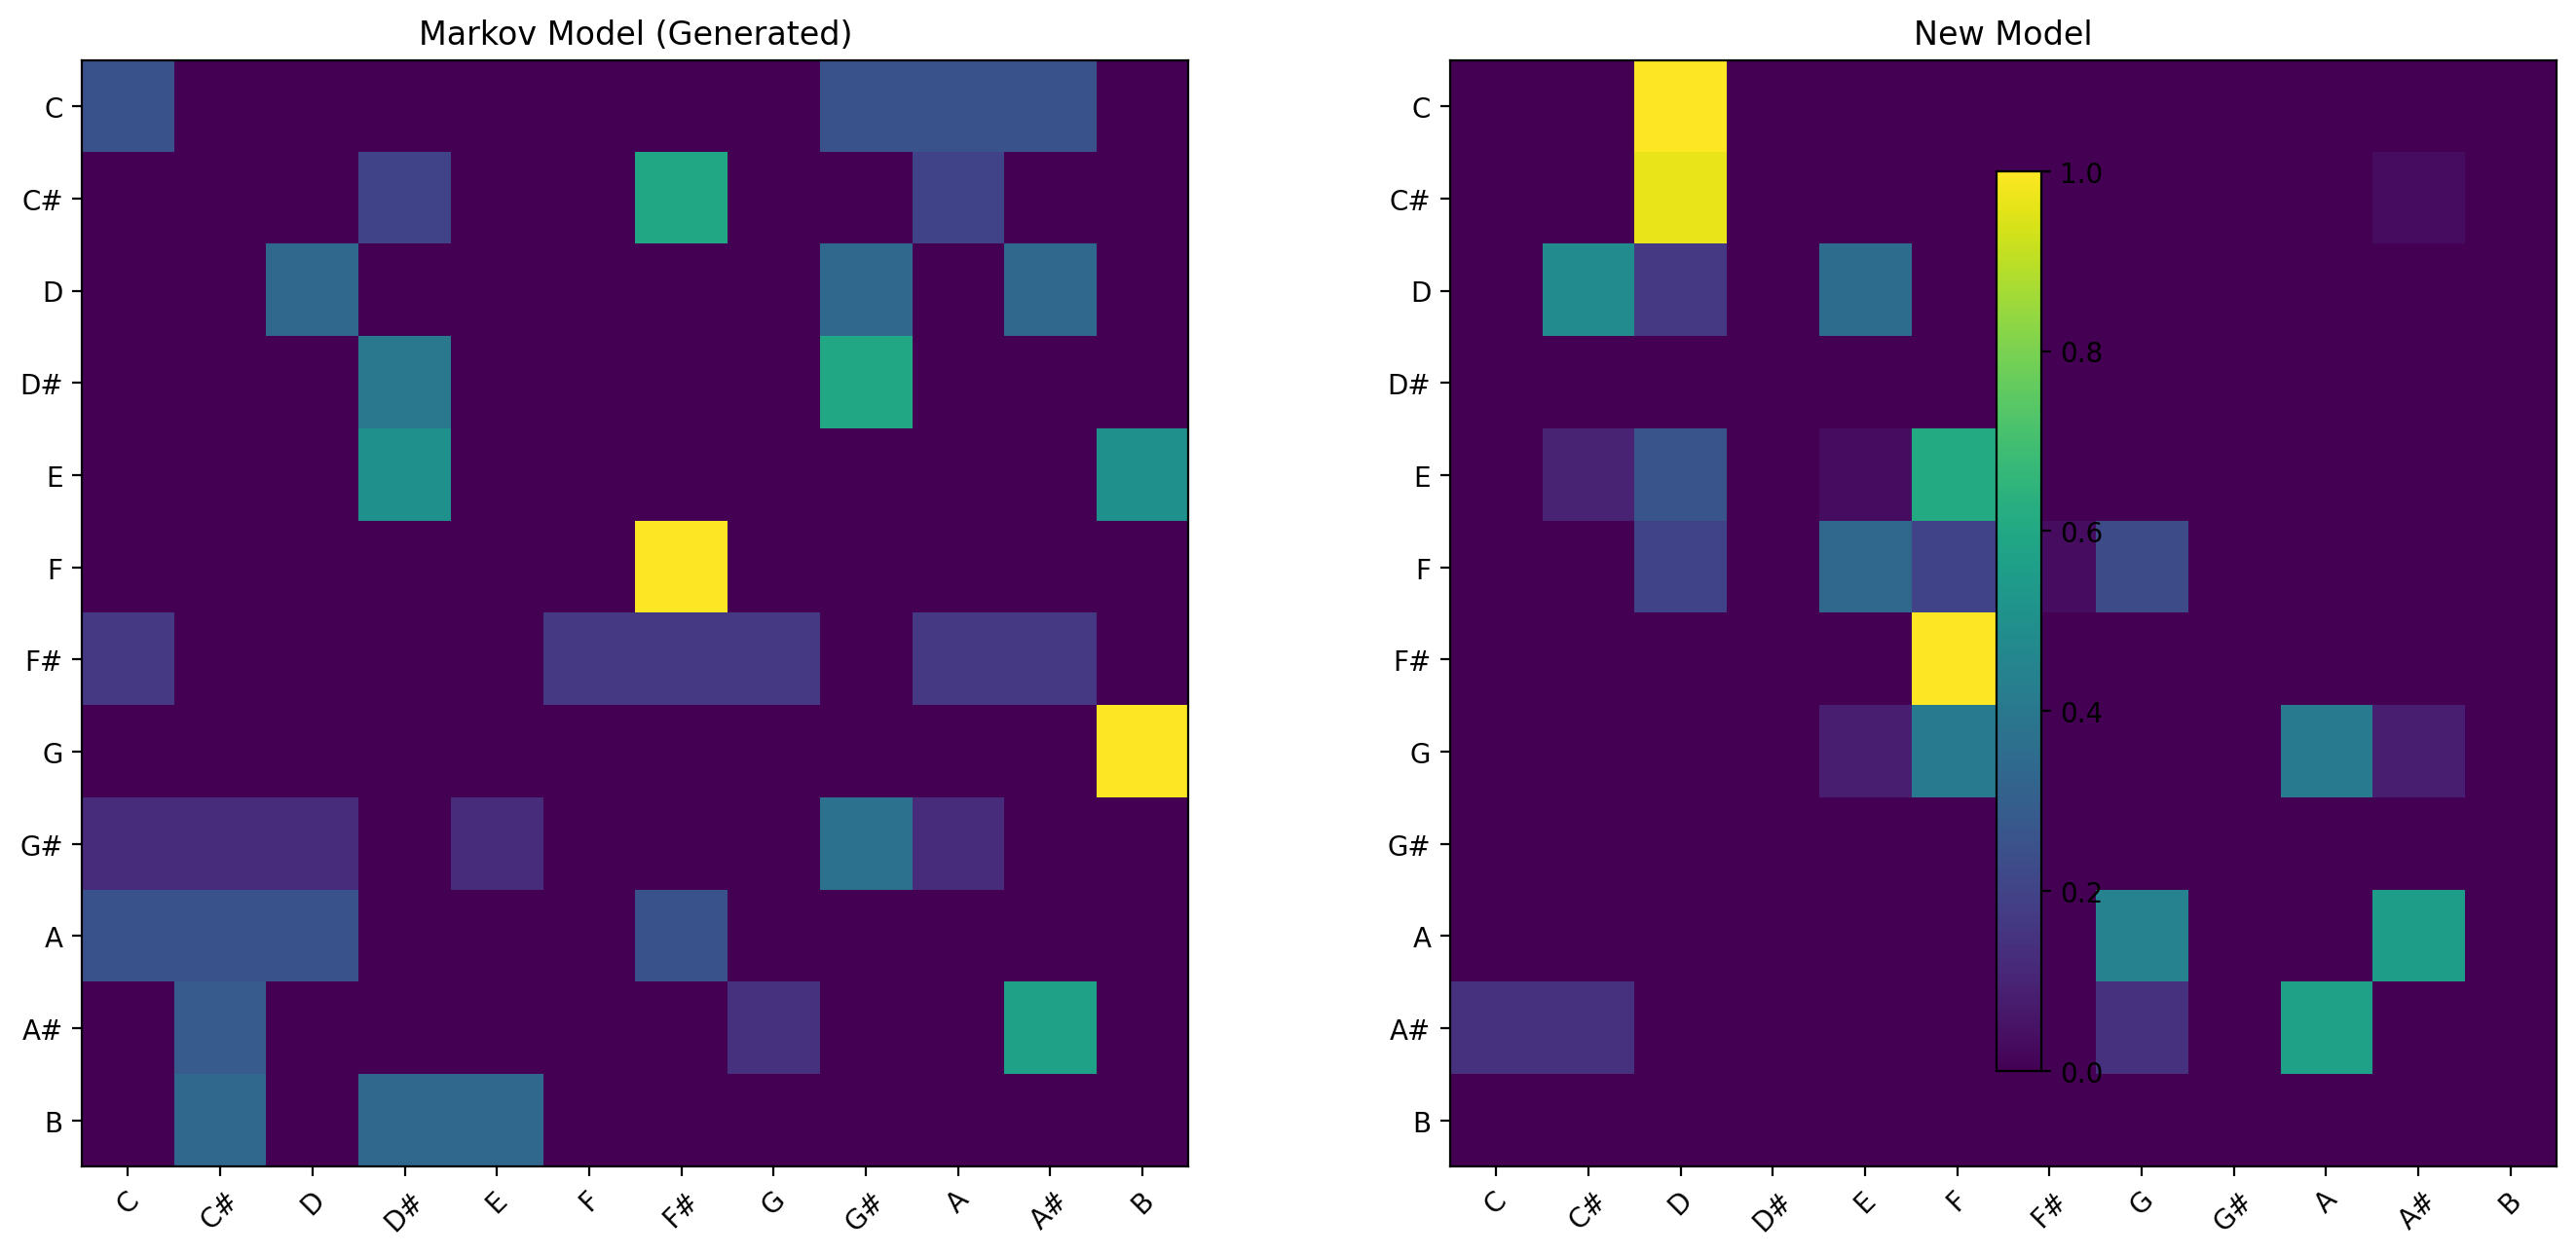

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from music21 import converter, note, chord

def extract_pitch_classes(midi_file):
    midi = converter.parse(midi_file)
    pitch_classes = []
    for el in midi.flat.notes:
        if isinstance(el, note.Note):
            pitch_classes.append(el.pitch.midi % 12)
        elif isinstance(el, chord.Chord):
            pitch_classes.extend([p.midi % 12 for p in el.pitches])
    return pitch_classes

def compute_transition_matrix(pitch_classes):
    matrix = np.zeros((12, 12))
    for i in range(len(pitch_classes) - 1):
        curr = pitch_classes[i]
        next_ = pitch_classes[i + 1]
        matrix[curr, next_] += 1
    row_sums = matrix.sum(axis=1, keepdims=True)
    matrix = matrix / np.maximum(row_sums, 1)  # normalize
    return matrix

def plot_comparison_matrix(matrix1, matrix2, title1, title2):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    
    for ax, mat, title in zip(axes, [matrix1, matrix2], [title1, title2]):
        im = ax.imshow(mat, cmap='viridis')
        ax.set_title(title)
        ax.set_xticks(range(12))
        ax.set_yticks(range(12))
        ax.set_xticklabels(labels, rotation=45)
        ax.set_yticklabels(labels)
    fig.colorbar(im, ax=axes.ravel().tolist())
    plt.tight_layout()
    plt.show()

# Example usage:
gen_pcs = extract_pitch_classes("sample_generated.mid")  # Markov output
ref_pcs = extract_pitch_classes("sample.mid")  # New model output

gen_mat = compute_transition_matrix(gen_pcs)
ref_mat = compute_transition_matrix(ref_pcs)

plot_comparison_matrix(gen_mat, ref_mat, "Markov Model (Generated)", "New Model")
